In [1]:
import numpy as np
import torch

from floody import data as D
from floody import floody as F

In [2]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline 

In [3]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

In [4]:
# miami
all_city_zipcodes = np.array([33012, 33015, 33186, 33157, 33033, 33027, 33178, 33142, 33177, 33032, 33161, 33165, 33196, 33125, 33176, 33018, 33175, 33193, 33126, 33016, 33179, 33147, 33162, 33155, 33169, 33010, 33160, 33172, 33014, 33134, 33055, 33030, 33056, 33139, 33183, 33135, 33141, 33180, 33121, 33174, 33013, 33130, 33150, 33133, 33143, 33156, 33173, 33127, 33145, 33054, 33144, 33138, 33185, 33166, 33167, 33189, 33168, 33140, 33184, 33131, 33137, 33181, 33034, 33187, 33136, 33154, 33146, 33149, 33035, 33129, 33182, 33170, 33190, 33132, 33037, 33128, 33110, 33031, 33194, 33158, 34141, 33122, 33148, 33199, 33039, 33109, 33191, 33107, 33159, 33256, 33002, 33011, 33164, 33163, 33188, 33192, 33197, 33233, 33231, 33238, 33234, 33242, 33239, 33245, 33247, 33257, 33265, 33261, 33269, 33266, 33283, 33280, 33299, 33296, 33090, 33092, 33101, 33102, 33112, 33111, 33116, 33114, 33119, 33124, 33152, 33151, 33153, 33206, 33198, 33195, 33017, 33222, 33106, 33243, 33255])
print(len(all_city_zipcodes))

135


In [5]:
_data = D._load_data('tl_2022_us_zcta520/tl_2022_us_zcta520.shp', dtype='gpd')

city_zipcodes, missing_zipcodes = [], []
for z in all_city_zipcodes: 
    if z not in np.array(_data['ZCTA5CE20']).astype(int): 
        missing_zipcodes.append(z)
    elif z in [33101, 34141]: 
        missing_zipcodes.append(z)
    else: 
        city_zipcodes.append(z)
        
city_zipcodes = np.array(city_zipcodes)
print(len(city_zipcodes))

81


In [6]:
city_zipcodes

array([33012, 33015, 33186, 33157, 33033, 33027, 33178, 33142, 33177,
       33032, 33161, 33165, 33196, 33125, 33176, 33018, 33175, 33193,
       33126, 33016, 33179, 33147, 33162, 33155, 33169, 33010, 33160,
       33172, 33014, 33134, 33055, 33030, 33056, 33139, 33183, 33135,
       33141, 33180, 33174, 33013, 33130, 33150, 33133, 33143, 33156,
       33173, 33127, 33145, 33054, 33144, 33138, 33185, 33166, 33167,
       33189, 33168, 33140, 33184, 33131, 33137, 33181, 33034, 33187,
       33136, 33154, 33146, 33149, 33035, 33129, 33182, 33170, 33190,
       33132, 33037, 33128, 33031, 33194, 33158, 33122, 33039, 33109])

In [6]:
city = D.read_zipshape(city_zipcodes)

# compile covariates:
1. mean_monthly_rainfall
2. flood_risk100
3. median_household_income
4. population
5. renter_fraction 
6. educated_fraction
7. white_fraction

These are the input for CausalFlow

In [7]:
X_2022 = D.get_X(np.array(city['ZIPCODE']).astype(int), np.array(city['LATITUDE']).astype(float), 
                 np.array(city['LONGITUDE']).astype(float), 2022)
X_2030 = D.get_X(np.array(city['ZIPCODE']).astype(int), np.array(city['LATITUDE']).astype(float), 
                 np.array(city['LONGITUDE']).astype(float), 2030)
X_2040 = D.get_X(np.array(city['ZIPCODE']).astype(int), np.array(city['LATITUDE']).astype(float), 
                 np.array(city['LONGITUDE']).astype(float), 2040)
X_2052 = D.get_X(np.array(city['ZIPCODE']).astype(int), np.array(city['LATITUDE']).astype(float), 
                 np.array(city['LONGITUDE']).astype(float), 2052)

In [8]:
xlim = (-80.8, -80.1)
ylim = (25.3, 26.05)

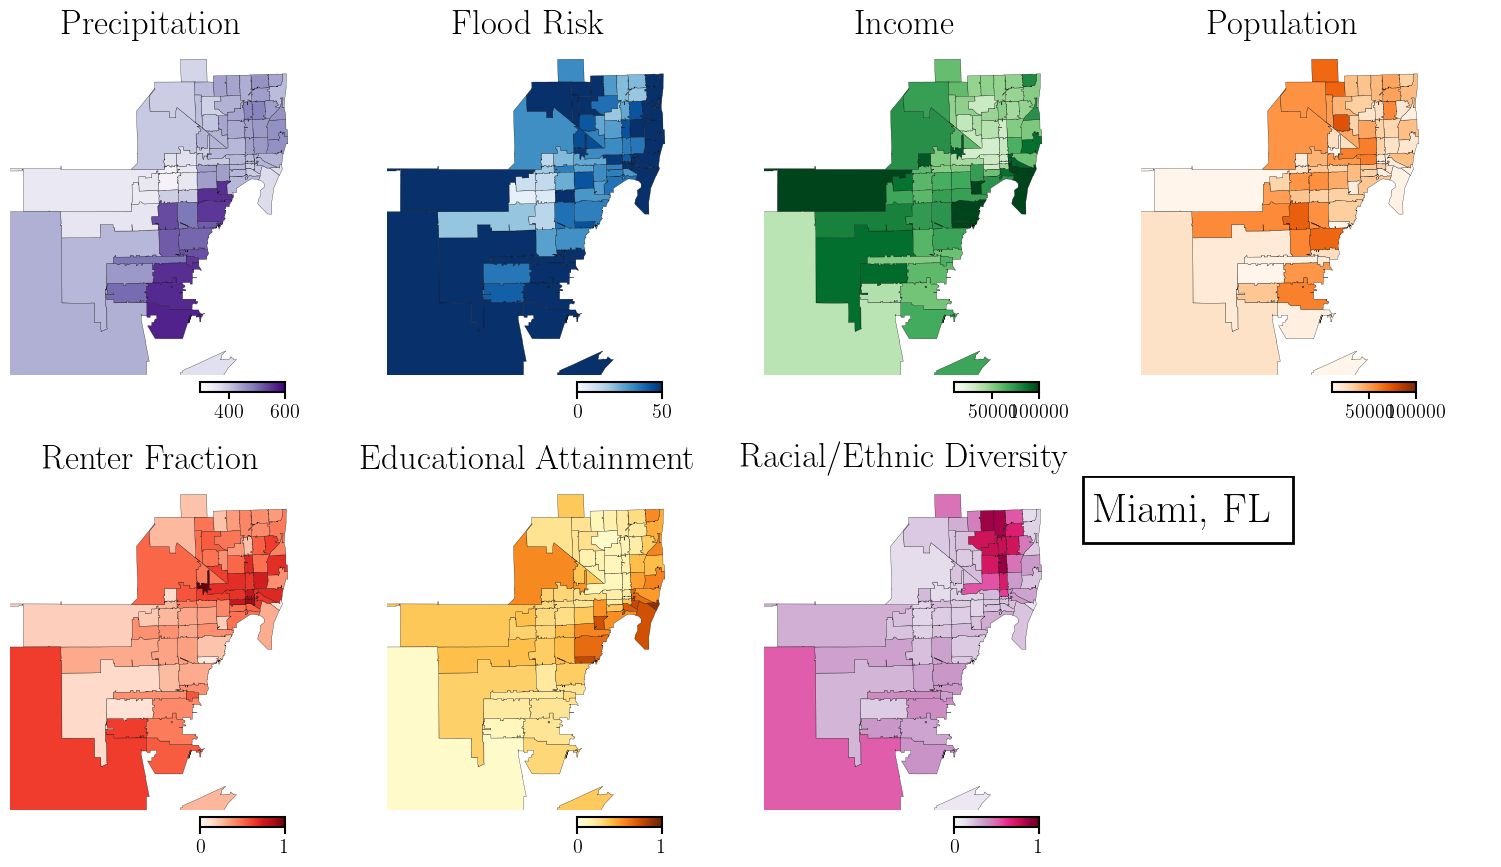

In [9]:
rng = [(300., 600.), (0., 50.), (1e4, 1e5), (1e4, 1e5), (0., 1.), (0., 1.), (0., 1.)]

fig = plt.figure(figsize=(20,10))
for i in range(7): 
    ax = fig.add_subplot(2,4,i+1)
    
    if i == 6: city['blanck'] = 1.-X_2022[:,i]        
    else: city['blanck'] = X_2022[:,i]

    ax = city.plot(column='blanck', 
                   cmap=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'PuRd'][i],
                   edgecolor='k', linewidth=0.2, vmin=rng[i][0], vmax=rng[i][1], ax=ax)
    
    lbl = ['Precipitation', 'Flood Risk', 'Income', 'Population', 
           'Renter Fraction', 'Educational Attainment', r'Racial/Ethnic Diversity'][i]
    ax.text(0.5, 1., lbl, transform=ax.transAxes, ha='center', va='bottom', fontsize=25)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_axis_off()
    
    sc = ax.scatter([], [], c=[], cmap=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'PuRd'][i], 
                    vmin=rng[i][0], vmax=rng[i][1])
    cbaxes = inset_axes(ax, width="30%", height="3%", bbox_to_anchor=(0, -1., 1, 1.), bbox_transform=ax.transAxes)    
    cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')

ax = fig.add_subplot(2,4,8)
ax.text(0.05, 0.95, 'Miami, FL', transform=ax.transAxes, ha='left', va='top', fontsize=30)
rect = patches.Rectangle((0.025, 0.8), 0.5, 0.2, edgecolor='k', linewidth=2, facecolor='None', transform=ax.transAxes)
ax.add_patch(rect)
ax.set_axis_off()  

fig.subplots_adjust(hspace=0.3, wspace=-0.1)

In [10]:
median_losses = np.zeros((4, X_2022.shape[0]))

for i, zcode in enumerate(np.array(city['ZIPCODE']).astype(int)): 
    for j, _X in enumerate([X_2022, X_2030, X_2040, X_2052]):
        try: 
            _losses = F.flood_loss(_X[i,0], _X[i,1], _X[i,2], _X[i,3], _X[i,4], _X[i,5], _X[i,6],
                              Nsample=10000, support_threshold=0.99, device=None)
        except ValueError:
            print(zcode, _X[i,:])
            
        median_losses[j, i] = np.median(_losses)
        
# save to file 
np.save('data/miami.median_flood_losses.npy', median_losses)        

/home/chhahn/projects/floody/src/floody/floody.py:43: UserWarning: X is out of support
  if not in_support: warnings.warn("X is out of support")


In [ ]:
median_losses = np.load('data/miami.median_flood_losses.npy')

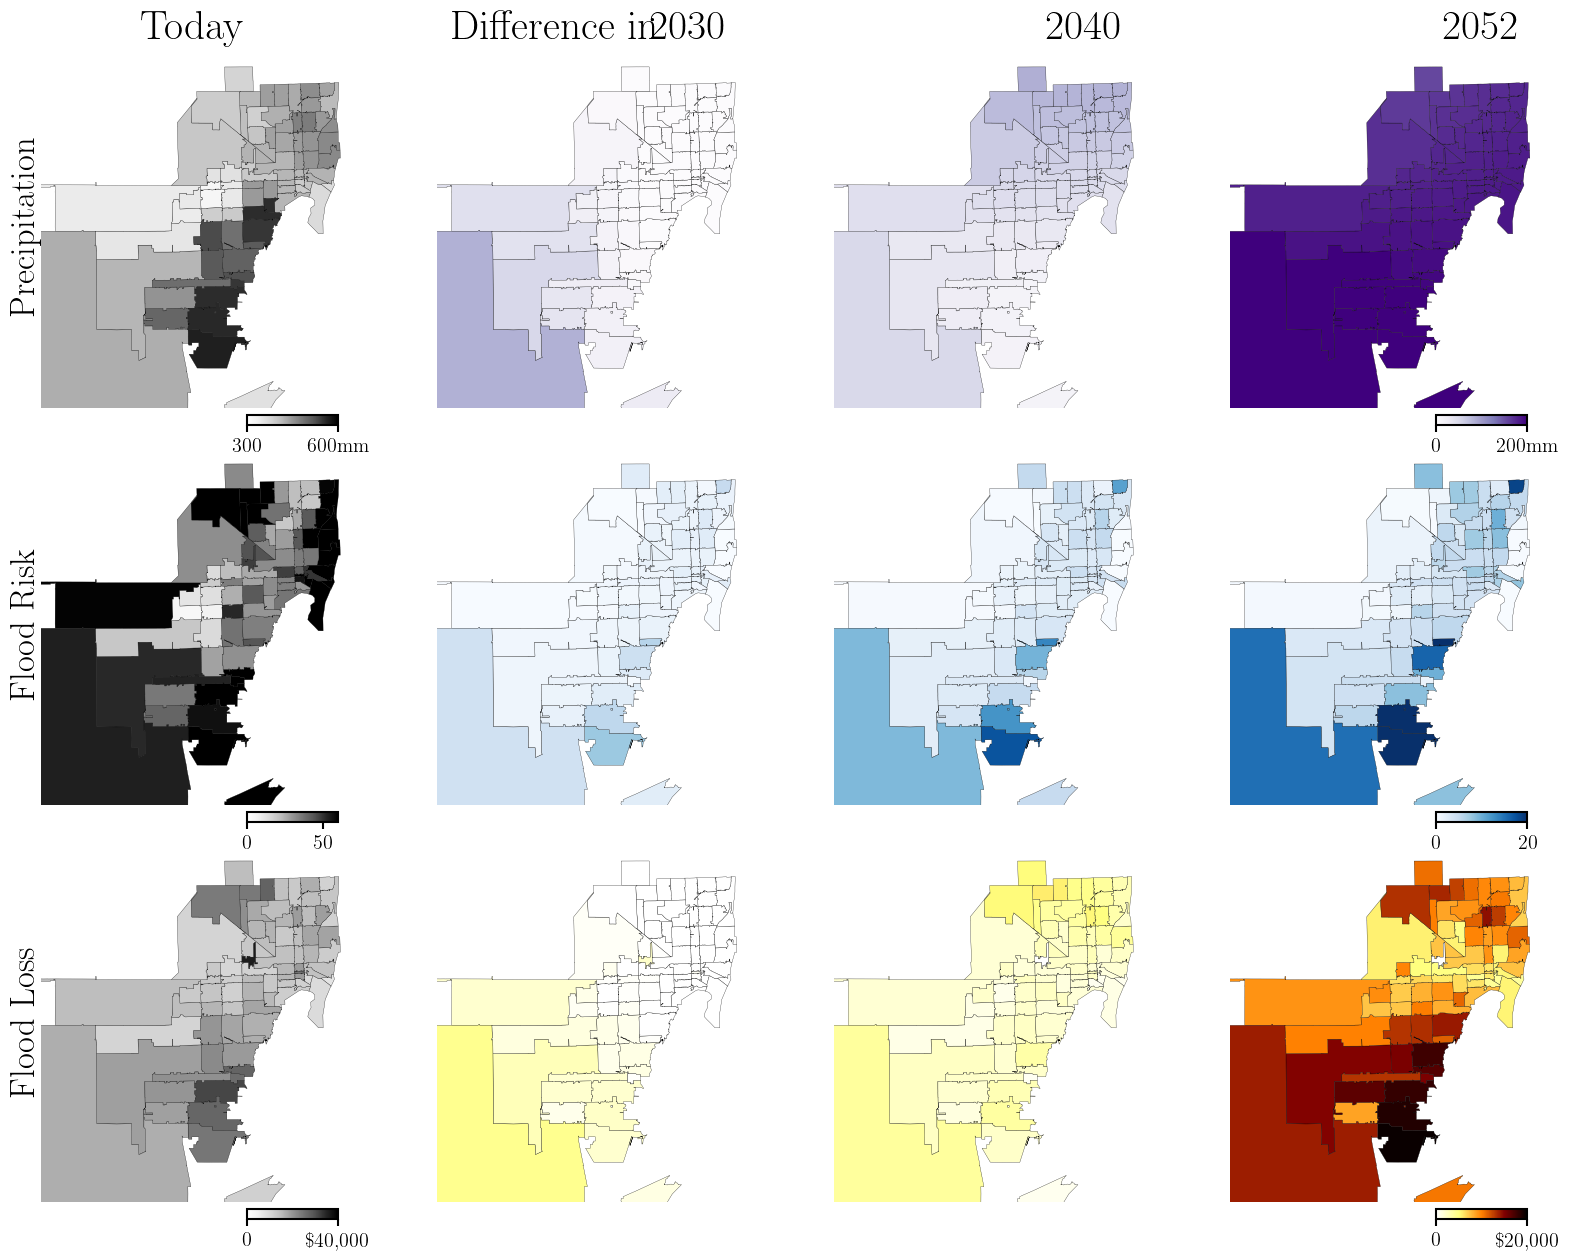

In [12]:
# create map figure and axes
fig = plt.figure(figsize=(20,15))
for i in range(4): 
    ax = fig.add_subplot(3,4,i+1)
    
    if i == 0: city['blanck'] = X_2022[:,0]
    else: city['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,0] - X_2022[:,0]
    ax = city.plot(column='blanck', cmap=['Greys', 'Purples'][i != 0], edgecolor='k', linewidth=0.2, 
                      vmin=[0., 300.][i == 0], vmax=[200., 600][i == 0], ax=ax)
    
    if i == 0: ax.text(0.0, 0.5, 'Precipitation', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    if i == 1: ax.text(0.05, 1.0, 'Difference in', transform=ax.transAxes, ha='left', va='bottom', fontsize=30)
    if i == 0: ax.set_title('Today', fontsize=30)
    else: ax.text(0.95, 1.0, ['2030', '2040', '2052'][i-1], transform=ax.transAxes, ha='right', va='bottom', fontsize=30)    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)        
    ax.set_axis_off()
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Purples'][i != 0], 
                        vmin=[0., 300.][i == 0], vmax=[200., 600][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", bbox_to_anchor=(0, -1., 1, 1.), bbox_transform=ax.transAxes) 
        cbar = plt.colorbar(sc, ticks=[[0., 300.][i == 0], [200., 600.][i==0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels([['0', '300'][i == 0], ['200mm', '600mm'][i==0]])

    # Flood risk
    ax = fig.add_subplot(3,4,i+5)
    if i == 0: city['blanck'] = X_2022[:,1]
    else: city['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,1] - X_2022[:,1]
    
    ax = city.plot(column='blanck', cmap=['Greys', 'Blues'][i != 0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i == 0], vmax=[20., 60][i == 0], ax=ax)

    if i == 0: ax.text(0.0, 0.5, 'Flood Risk', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Blues'][i != 0], 
                        vmin=[0., 0.][i == 0], vmax=[20., 60][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", bbox_to_anchor=(0, -1., 1, 1.), bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')    

    
    # flood loss
    ax = fig.add_subplot(3,4,i+9)
    if i == 0: city['blanck'] = median_losses[0,:]
    else: city['blanck'] = median_losses[i,:] - median_losses[0,:]
    ax = city.plot(column='blanck', cmap=['Greys', 'afmhot_r'][i != 0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i == 0], vmax=[2e4, 4e4][i == 0], ax=ax)
    
    if i == 0: ax.text(0.0, 0.5, 'Flood Loss', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'afmhot_r'][i != 0], 
                        vmin=[0., 0.][i == 0], vmax=[2e4, 4e4][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", bbox_to_anchor=(0, -1., 1, 1.), bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, ticks=[0, [2e4, 4e4][i == 0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels(['0', [r'\$20,000', r'\$40,000'][i==0]])
    
fig.subplots_adjust(hspace=0.1, wspace=0.1)

In [13]:
savings = []
for i, zcode in enumerate(np.array(city['ZIPCODE']).astype(int)): 
    _savings = []
    for j, _X in enumerate([X_2022, X_2030, X_2040, X_2052]):
        _saving = F.flood_saving(_X[i,0], _X[i,1], _X[i,2], _X[i,3], _X[i,4], _X[i,5], _X[i,6],
                          Nsample=10000, support_threshold=0.99, device=None)
        _savings.append(_saving)
    savings.append(_savings)
    
savings = np.array(savings)
# save to file 
np.save('data/miami.flood_savings.npy', savings)

/home/chhahn/projects/CausalFlow/src/causalflow/causalflow.py:329: UserWarning: covariate is out of the treated sample support!
  warnings.warn("covariate is out of the treated sample support!")
/home/chhahn/projects/CausalFlow/src/causalflow/causalflow.py:331: UserWarning: covariate is out of the control sample support!
  warnings.warn("covariate is out of the control sample support!")


In [ ]:
savings = np.load('data/miami.flood_savings.npy')

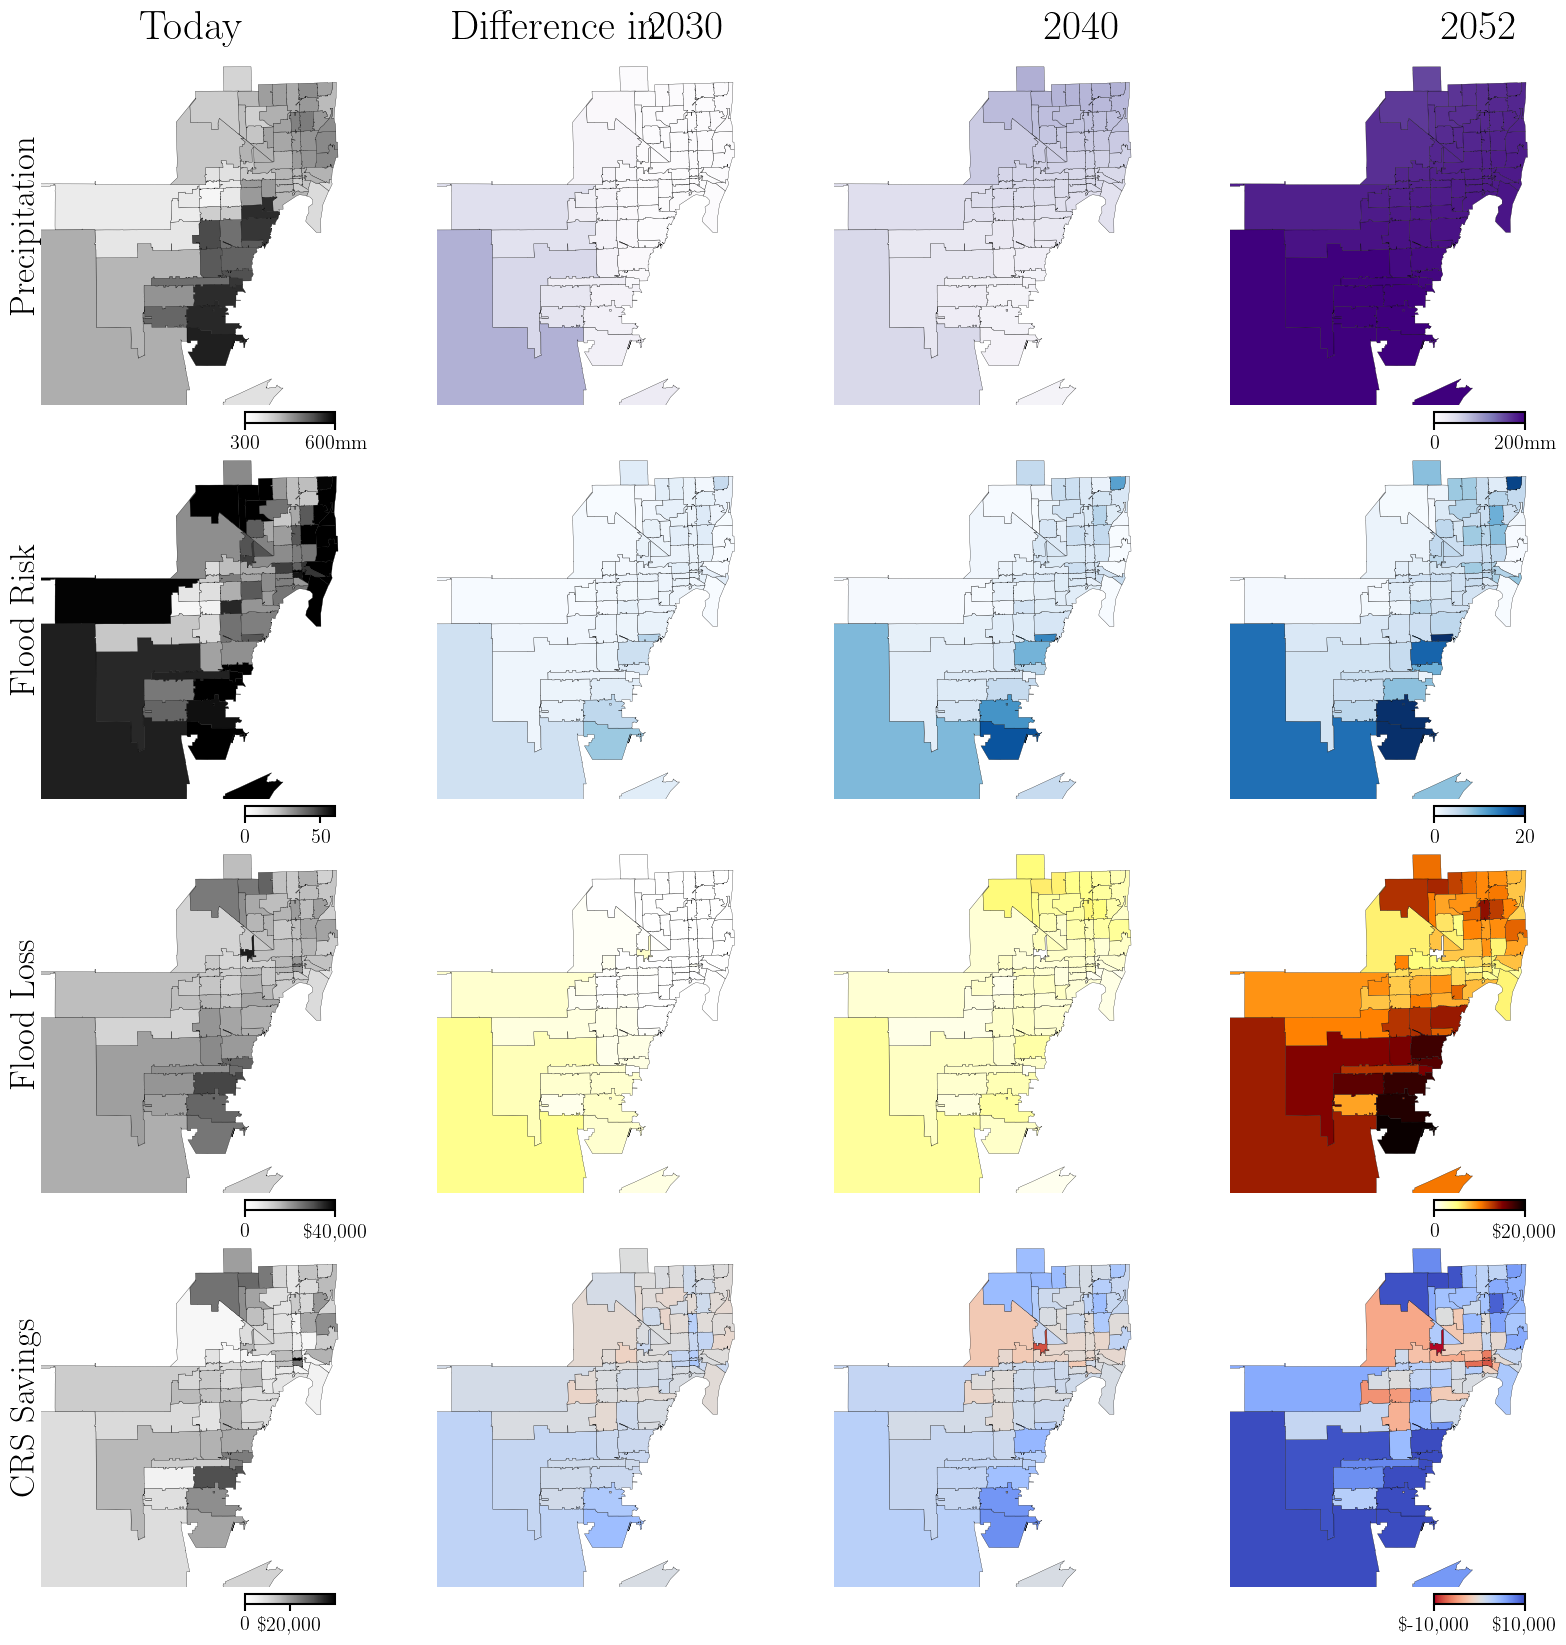

In [15]:
fig = plt.figure(figsize=(20,20))

for i in range(4): 
    ax = fig.add_subplot(4,4,i+1)
    
    if i == 0: city['blanck'] = X_2022[:,0]
    else: city['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,0] - X_2022[:,0]
    ax = city.plot(column='blanck', cmap=['Greys', 'Purples'][i != 0], edgecolor='k', linewidth=0.2, 
                      vmin=[0., 300.][i == 0], vmax=[200., 600][i == 0], ax=ax)
    
    if i == 0: ax.text(0.0, 0.5, 'Precipitation', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    if i == 1: ax.text(0.05, 1.0, 'Difference in', transform=ax.transAxes, ha='left', va='bottom', fontsize=30)
    if i == 0: ax.set_title('Today', fontsize=30)
    else: ax.text(0.95, 1.0, ['2030', '2040', '2052'][i-1], transform=ax.transAxes, ha='right', va='bottom', fontsize=30)    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)        
    ax.set_axis_off()
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Purples'][i != 0], 
                        vmin=[0., 300.][i == 0], vmax=[200., 600][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", bbox_to_anchor=(0, -1., 1, 1.), bbox_transform=ax.transAxes) 
        cbar = plt.colorbar(sc, ticks=[[0., 300.][i == 0], [200., 600.][i==0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels([['0', '300'][i == 0], ['200mm', '600mm'][i==0]])

    # Flood risk
    ax = fig.add_subplot(4,4,i+5)
    if i == 0: city['blanck'] = X_2022[:,1]
    else: city['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,1] - X_2022[:,1]
    
    ax = city.plot(column='blanck', cmap=['Greys', 'Blues'][i != 0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i == 0], vmax=[20., 60][i == 0], ax=ax)

    if i == 0: ax.text(0.0, 0.5, 'Flood Risk', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Blues'][i != 0], 
                        vmin=[0., 0.][i == 0], vmax=[20., 60][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", bbox_to_anchor=(0, -1., 1, 1.), bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')    

    
    # flood loss
    ax = fig.add_subplot(4,4,i+9)
    if i == 0: city['blanck'] = median_losses[0,:]
    else: city['blanck'] = median_losses[i,:] - median_losses[0,:]
    ax = city.plot(column='blanck', cmap=['Greys', 'afmhot_r'][i != 0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i == 0], vmax=[2e4, 4e4][i == 0], ax=ax)
    
    if i == 0: ax.text(0.0, 0.5, 'Flood Loss', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'afmhot_r'][i != 0], 
                        vmin=[0., 0.][i == 0], vmax=[2e4, 4e4][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", bbox_to_anchor=(0, -1., 1, 1.), bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, ticks=[0, [2e4, 4e4][i == 0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels(['0', [r'\$20,000', r'\$40,000'][i==0]])
        
    
    # CFS flood saving
    ax = fig.add_subplot(4,4,i+13)
    if i == 0: city['blanck'] = -savings[:,0] + 9780.0 # outreach impact
    else: city['blanck'] = -savings[:,i] + savings[:,0]
    
    ax = city.plot(column='blanck', cmap=['Greys', 'coolwarm_r'][i!=0], edgecolor='k', linewidth=0.2,  
                      vmin=[-1e4, 0.][i==0], vmax=[1e4, 4e4][i==0], ax=ax)
    if i == 0: ax.text(0.0, 0.5, 'CRS Savings', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'coolwarm_r'][i!=0], 
                        vmin=[-10000., 0.][i==0], vmax=[1e4, 4e4][i==0])
        cbaxes = inset_axes(ax, width="30%", height="3%", bbox_to_anchor=(0, -1., 1, 1.), bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, ticks=[[-1e4, 0.][i==0], [1e4, 2e4][i==0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels([[r'\$-10,000', '0'][i==0], [r'\$10,000', r'\$20,000'][i==0]])        
    
fig.subplots_adjust(hspace=0.1, wspace=0.1)